In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
import lightgbm as lgb
import os



/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = v

## Loading the Dataset

In [3]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

data = pd.read_csv('./adult/adult.data', names=columns,na_values=' ?')

print('Data shape:', data.shape)

Data shape: (32561, 15)


In [4]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
data['income'] = data['income'].apply(lambda x:x.strip())

Converting the key categorial attributes (age, sex) and the target (income) into binary numerical:

In [11]:
data['income'] = data['income'].apply(lambda x: 1 if x=='>50K' else 0)
data['age'] = data['age'].apply(lambda x: "Senior" if x>25 else "Young")
data['age_cat'] = data['age'].apply(lambda x: 1 if x == "Senior" else 0)
data['sex_cat'] = data['sex'].apply(lambda x: 1 if x == " Male" else 0)
data['age_cat_private'] = data['age_cat']
data['sex_cat_private'] = data['sex_cat']

## Privacy

#### Cross-tabulation (contingency table)

In [15]:
cross_tab_original = pd.crosstab(data['age'], data['sex'], margins=True)


In [17]:
cross_tab_original

sex,Female,Male,All
age,,,
Senior,7950,18200,26150
Young,2821,3590,6411
All,10771,21790,32561


The contingency tables show that in value combinations of the two sensitive attributes - sex and age - the majority are Senior Males, and Young Females are the least represented category.

In [21]:
cross_tab_with_target = pd.crosstab(
    [data['age'], data['sex']], 
    data['income'], margins=True
)

In [23]:
cross_tab_with_target

income              0     1    All
age    sex                        
Senior  Female   6803  1147   7950
        Male    11620  6580  18200
Young   Female   2789    32   2821
        Male     3508    82   3590
All             24720  7841  32561

When including the target variable in the cross-tabulation for exploratory data analysis purposes, we observe that the Senior Male category accounts for approximately 5 out of every 6 individuals with an income exceeding 50K in the training dataset.

#### Local Differential Privacy (randomized response)

Smaller values of $\epsilon$ imply better privacy protection, they also imply less
accuracy due to noise addition compared to larger values of $\epsilon$.

We assume that $p = q$ and our implementation of randomized response takes $\epsilon$ as a parameter

In [29]:
def get_p_q(epsilon):
    p = np.exp(epsilon)/(1+np.exp(epsilon))
    return p, p

In [31]:
get_p_q(0.5)

(0.6224593312018546, 0.6224593312018546)

In [33]:
sensitive_attributes = ['age_cat','sex_cat']

In [35]:
def rand_resp(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    toss = np.random.random()
    if x == 0:
        y = 0 if toss <= p else 1
    else:
        y = 1 if toss <= p else 0
    return y

In [37]:
def apply_ldp(data, sensitive_columns, epsilon):
    print(f"Applying LDP with epsilon = {epsilon}")
    private_data = data.copy()

    for col in sensitive_columns:
        private_data[f"{col}_private"] = private_data[col].apply(lambda x: rand_resp(x,epsilon))
        
    cross_tab_original = pd.crosstab(data[sensitive_columns[0]], data[sensitive_columns[1]])
    cross_tab_private = pd.crosstab(private_data[f"{sensitive_columns[0]}_private"], private_data[f"{sensitive_columns[1]}_private"])
    error_matrix = cross_tab_private - cross_tab_original
    total_error = np.abs(error_matrix).sum().sum()

    result = {
        'epsilon': epsilon,
        'cross_tab_original': cross_tab_original,
        'cross_tab_private': cross_tab_private,
        'error_matrix': error_matrix,
        'total_error': total_error
    }

    return private_data, result


In [39]:
epsilon_values = [0.01, 0.1, 0.25, 0.5, 1, 2, 3, 5, 10]
all_results = {}

for epsilon in epsilon_values:
    _, result = apply_ldp(data, sensitive_attributes, epsilon)
    all_results[epsilon] = result

    print("\nOriginal Cross-Tabulation:")
    print(result['cross_tab_original'])

    print("\nPrivate Cross-Tabulation:")
    print(result['cross_tab_private'])

    print("\nError Matrix:")
    print(result['error_matrix'])

    print(f"Total Error: {result['total_error']}")

Applying LDP with epsilon = 0.01

Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        2821   3590
1        7950  18200

Private Cross-Tabulation:
sex_cat_private     0     1
age_cat_private            
0                8146  7982
1                8148  8285

Error Matrix:
sex_cat_private     0     1
age_cat_private            
0                5325  4392
1                 198 -9915
Total Error: 19830
Applying LDP with epsilon = 0.1

Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        2821   3590
1        7950  18200

Private Cross-Tabulation:
sex_cat_private     0     1
age_cat_private            
0                7798  8057
1                8200  8506

Error Matrix:
sex_cat_private     0     1
age_cat_private            
0                4977  4467
1                 250 -9694
Total Error: 19388
Applying LDP with epsilon = 0.25

Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        2821   3590
1        7950  18

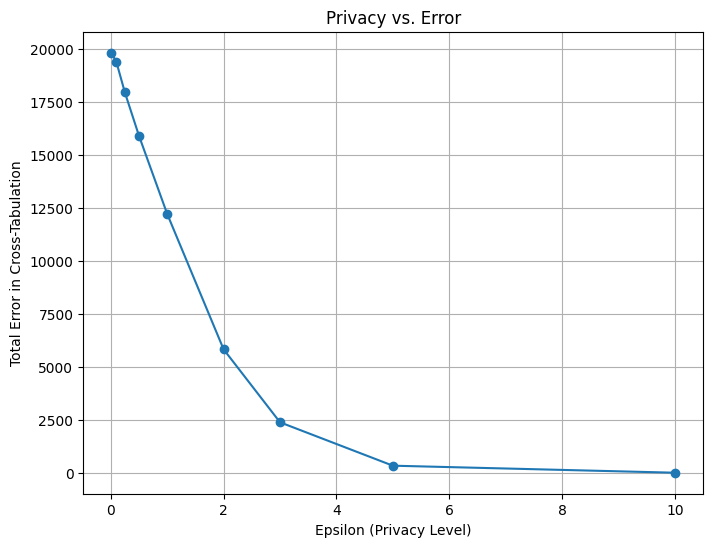

In [41]:
epsilons = list(all_results.keys())
total_errors = [all_results[epsilon]['total_error'] for epsilon in epsilons]

plt.figure(figsize=(8, 6))
plt.plot(epsilons, total_errors, marker='o')
plt.xlabel("Epsilon (Privacy Level)")
plt.ylabel("Total Error in Cross-Tabulation")
plt.title("Privacy vs. Error")
plt.grid()
plt.show()

In [43]:
def compute_variance(epsilon, df,n_trials=30):

    original_df = df.copy()
    
    cross_tab_original = pd.crosstab(original_df['age_cat'], original_df['sex_cat'], margins=False)
    tab_size = cross_tab_original.size
    
    variances = []
    for i in range(n_trials):
        original_df['age_cat_private'] = original_df['age_cat'].apply(lambda x: rand_resp(x,epsilon))
        original_df['sex_cat_private'] = original_df['sex_cat'].apply(lambda x: rand_resp(x,epsilon))
        privacy_cross_tab = pd.crosstab(original_df['age_cat_private'], original_df['sex_cat_private'], margins=False)
        
        variances.append(np.sum((cross_tab_original-privacy_cross_tab)**2)/tab_size)


    mean_variance = np.mean(variances) 
    std_dev_variance = np.std(variances)


    return mean_variance,std_dev_variance
    

In [45]:
variance_dict = {}

for epsilon in np.arange(0,10,0.5): 

    mean,std_dev = compute_variance(epsilon,data,n_trials=50)

    variance_dict[epsilon] = {
        "mean": mean,
        "std_dev" : std_dev
    }


/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return 

In [46]:
variance_dict

{0.0: {'mean': 18782180.295, 'std_dev': 11658664.557704423},
 0.5: {'mean': 11597681.08, 'std_dev': 8285131.336278524},
 1.0: {'mean': 6387091.575, 'std_dev': 4986315.529548369},
 1.5: {'mean': 3119756.785, 'std_dev': 2536381.968435426},
 2.0: {'mean': 1397861.755, 'std_dev': 1173877.832769446},
 2.5: {'mean': 583622.265, 'std_dev': 493379.12790316844},
 3.0: {'mean': 236045.69, 'std_dev': 202199.162284575},
 3.5: {'mean': 92067.845, 'std_dev': 79095.28079277849},
 4.0: {'mean': 34111.245, 'std_dev': 29572.54044912231},
 4.5: {'mean': 13273.915, 'std_dev': 11745.971388694295},
 5.0: {'mean': 4960.74, 'std_dev': 4298.799885276122},
 5.5: {'mean': 1953.51, 'std_dev': 1762.7956010695057},
 6.0: {'mean': 655.81, 'std_dev': 609.2965289167499},
 6.5: {'mean': 280.19, 'std_dev': 254.78527999081896},
 7.0: {'mean': 111.54, 'std_dev': 116.40072336544992},
 7.5: {'mean': 40.58, 'std_dev': 43.61693879675647},
 8.0: {'mean': 19.445, 'std_dev': 21.765183780524346},
 8.5: {'mean': 8.085, 'std_dev': 

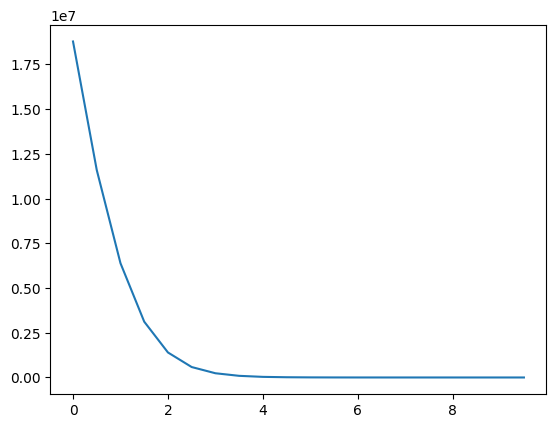

In [49]:
x = np.arange(0,10,0.5)
y = [variance_dict[i]['mean'] for i in np.arange(0,10,0.5)]

plt.plot(x,y)
plt.show()

The analysis shows the influence of the chosen $\epsilon$ values on the number of errors in the estimation of how many people exist in value combinations of the two sensitive attributes when applying randomized response mechanism of local differential privacy. The main observation is that with higher $\epsilon$ values the number of errors in the estimation decreases.

#### Creating the private dataset

In [53]:
epsilon = 0.5
private_data, result = apply_ldp(data, sensitive_attributes, epsilon)

Applying LDP with epsilon = 0.5


In [55]:
print("\nOriginal Cross-Tabulation:")
print(result['cross_tab_original'])

print("\nPrivate Cross-Tabulation:")
print(result['cross_tab_private'])

print("\nError Matrix:")
print(result['error_matrix'])

print(f"Total Error: {result['total_error']}")


Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        2821   3590
1        7950  18200

Private Cross-Tabulation:
sex_cat_private     0      1
age_cat_private             
0                6340   7498
1                8607  10116

Error Matrix:
sex_cat_private     0     1
age_cat_private            
0                3519  3908
1                 657 -8084
Total Error: 16168


In [57]:
private_data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_cat,sex_cat,age_cat_private,sex_cat_private
0,Senior,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1,1,1,1
1,Senior,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,1,1,1,1
2,Senior,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1,1,1,0
3,Senior,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1,1,1,1
4,Senior,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,Senior,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,1,0,1,0
32557,Senior,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,1,1,1,1
32558,Senior,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,1,0,0,0
32559,Young,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0,1,0,1


#### Splitting the data

In [60]:
X = private_data.drop('income', axis=1)
y = private_data['income']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_data = X_train_val.copy()
train_data['income'] = y_train_val
test_data = X_test.copy()
test_data['income'] = y_test
train_data = train_data.dropna().reset_index(drop=True)
test_data = test_data.dropna().reset_index(drop=True)


In [62]:
print("Train Data Shape:",train_data.shape)
print("Test Data Shape:",test_data.shape)

Train Data Shape: (24134, 19)
Test Data Shape: (6028, 19)


In [64]:
test_data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,age_cat,sex_cat,age_cat_private,sex_cat_private,income
0,Senior,Self-emp-inc,117963,Doctorate,16,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,1,1,1,1,0
1,Senior,Self-emp-inc,385242,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,45,United-States,1,1,1,1,1
2,Senior,Private,164197,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,1,1,0,0,1
3,Senior,Private,92691,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,3,United-States,1,1,0,1,0
4,Senior,Private,106541,5th-6th,3,Married-civ-spouse,Other-service,Other-relative,White,Male,0,0,40,United-States,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023,Senior,Self-emp-not-inc,32185,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States,1,1,0,0,1
6024,Senior,Private,180714,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,2179,40,United-States,1,1,1,0,0
6025,Senior,Private,202027,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,1,1,0,1,1
6026,Senior,Private,125976,HS-grad,9,Separated,Sales,Unmarried,White,Female,0,0,35,United-States,1,0,1,0,0


#### Training the private classifier

In [67]:
os.makedirs("../model/lgbm_private", exist_ok=True)

In [69]:
def create_folds(df,n_folds):
    
    df['kfold'] = -1
    y = df.income
    
    kf = StratifiedKFold(n_splits=n_folds)
    
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,'kfold'] = f
        
    return df

In [71]:
models = {

    "lgbm" : LGBMClassifier(objective="binary",verbose=-1)

}

In [73]:
def run_folds(df,fold,model, epsilon_value):
    

    categorical_cols = [
                'workclass', 'education', 'marital_status', 'occupation',
                'relationship', 'race', 'native_country'
                        ]
    numerical_cols = [ 'fnlwgt','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex_cat_private','age_cat_private']

    preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
            ])

    
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    
    x_train = df_train.drop(columns=['income','age', 'sex', 'sex_cat', 'age_cat', 'kfold'],axis=1)
    y_train = df_train.income.values
    
    x_valid = df_valid.drop(columns=['income','age', 'sex', 'sex_cat', 'age_cat', 'kfold'],axis=1)
    y_valid = df_valid.income.values
    
    x_train = preprocessor.fit_transform(x_train)
    x_valid = preprocessor.transform(x_valid)
    
    
    clf = models[model]
    
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    y_valid_pred = clf.predict(x_valid)
    
    train_precision = precision_score(y_train, y_train_pred, average='macro')  
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    train_f1_score = f1_score(y_train, y_train_pred, average='macro')


    valid_precision = precision_score(y_valid, y_valid_pred, average='macro')  
    valid_recall = recall_score(y_valid, y_valid_pred, average='macro')
    valid_f1_score = f1_score(y_valid, y_valid_pred, average='macro')

    joblib.dump(preprocessor,f"../model/{model}_private/preprocessing_{fold}_private_{epsilon_value}.pkl")
    joblib.dump(clf,f"../model/{model}_private/{model}_{fold}_private_{epsilon_value}.pkl")



    print(f'Fold {fold}')
    print(f'Train F1 Score:{train_f1_score}, Train Precision:{train_precision}, Train Recall: {train_recall}')
    print(f'Validation F1 Score:{valid_f1_score}, Validation Precision:{valid_precision}, Validation Recall: {valid_recall}')
    print('*'*50)
    
    
    return train_precision, train_recall, train_f1_score , valid_precision, valid_recall, valid_f1_score



In [75]:
def get_stats(train_data,model_name,n_folds,epsilon_value):
    train_p = []
    train_r = []
    train_f1 = []
    val_p = []
    val_r = []
    val_f1 = []
    feature_names= []
    train_data = create_folds(train_data,n_folds)

    for i in range(n_folds):

        tp, tr, tf1, vp, vr, vf1= run_folds(train_data,i,model_name,epsilon_value)
        train_p.append(tp)
        train_r.append(tr)
        train_f1.append(tf1)
        val_p.append(vp)
        val_r.append(vr)
        val_f1.append(vf1)
    

    print("*"*15,f"Final Summary, Epsilon = {epsilon_value}","*"*15)

    print(f"average training precision:{np.array(train_p).mean()}")
    print(f"average training recall:{np.array(train_r).mean()}")
    print(f"average training f1:{np.array(train_f1).mean()}")


    print(f"average validation precision:{np.array(val_p).mean()}")
    print(f"average validation recall:{np.array(val_r).mean()}")
    print(f"average validation f1:{np.array(val_f1).mean()}")

    return 

In [77]:
epsilon_value=0.5
model="lgbm"

In [79]:
get_stats(train_data, model, 5, epsilon_value)

Fold 0
Train F1 Score:0.8331942764724684, Train Precision:0.859683385000214, Train Recall: 0.8142309195286996
Validation F1 Score:0.8085188674567363, Validation Precision:0.8405888082860975, Validation Recall: 0.7874392105112169
**************************************************
Fold 1
Train F1 Score:0.8333000822703263, Train Precision:0.8576623827222924, Train Recall: 0.8154858614355966
Validation F1 Score:0.8024492381149588, Validation Precision:0.8252420648898282, Validation Recall: 0.7860838831832004
**************************************************
Fold 2
Train F1 Score:0.8312284438633956, Train Precision:0.8580189498391877, Train Recall: 0.8121487409868529
Validation F1 Score:0.8161957693436396, Validation Precision:0.8353804730826976, Validation Recall: 0.8016188247245699
**************************************************
Fold 3
Train F1 Score:0.8361608358315122, Train Precision:0.8603482411676098, Train Recall: 0.8183927246769871
Validation F1 Score:0.7934023387727593, Validat

Fold 2 model has the best validation score, so for the rest of the modelling the fold 2 preprocessor and lgbm model will be used.

In [81]:
fold = 2

In [82]:
selected_processor = joblib.load(f"../model/{model}_private/preprocessing_{fold}_private_{epsilon_value}.pkl")
selected_model = joblib.load(f"../model/{model}_private/{model}_{fold}_private_{epsilon_value}.pkl")

### Model fairness assessment

In [87]:
X_test = test_data.drop(columns=['age','sex', 'age_cat','sex_cat', 'income'])
y_test = test_data.income

In [89]:
X_test=X_test.reset_index(drop=True)

In [91]:
X_test = selected_processor.transform(X_test)
y_test_prediction = selected_model.predict(X_test)

In [93]:
print(classification_report(y_test,y_test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4527
           1       0.78      0.64      0.71      1501

    accuracy                           0.87      6028
   macro avg       0.83      0.79      0.81      6028
weighted avg       0.86      0.87      0.86      6028



In [95]:
test_data['income_pred'] = y_test_prediction

In [97]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['income'],df['income_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predicted as positive
    
    return np.array([ACC, TPR, FPR, FNR, PPP])



## Accuracy Should is not a good indicator to check the fairness of the model
## True Positive Rate is percentage of people rightfully benefitted from the model
## False Negative rate is percentage of people who have wrongfully not benefitted from the model
## False Positive Rate is percentage of people who wrongfully benefitted from the model
## PPP (Disparate Impact) Percentage of people who will benefit from the model

In [99]:
def get_faireness_stats(lst,cols):

    return pd.DataFrame(lst,index=cols,
                        columns=['accuracy','true_positive_rate','false_positive_rate','false_negative_rate','disparate_impact'])

In [101]:
# Privileged Group is Senior and Unprivileged Group is Young

fm_age_1 = fairness_metrics(test_data[test_data.age=="Senior"])
fm_age_0 = fairness_metrics(test_data[test_data.age=="Young"])

#Get ratio of fairness metrics
fm_age = fm_age_0/fm_age_1


get_faireness_stats([fm_age_1,fm_age_0,fm_age],['Senior','Young','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
Senior,0.840345,0.646581,0.075383,0.353419,0.248512
Young,0.974892,0.541667,0.015915,0.458333,0.026840
ratio,1.160109,0.837740,0.211124,1.296855,0.108002


In [103]:
# Privileged Group is Male and Unprivileged Group is Female

fm_sex_1 = fairness_metrics(test_data[test_data.sex==" Male"])
fm_sex_0 = fairness_metrics(test_data[test_data.sex==" Female"])

#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1


get_faireness_stats([fm_sex_1,fm_sex_0,fm_sex],['male','female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
male,0.834851,0.653724,0.083542,0.346276,0.260645
female,0.930789,0.598326,0.023175,0.401674,0.093130
ratio,1.114916,0.915258,0.277406,1.159982,0.357305


In [105]:
fm_sex_1_age_1 = fairness_metrics(test_data[(test_data.sex==" Male")&(test_data.age=="Senior")])
fm_sex_0_age_0 = fairness_metrics(test_data[(test_data.sex==" Female")&(test_data.age=="Young")])

#Get ratio of fairness metrics
fm_sex_age = fm_sex_0_age_0/fm_sex_1_age_1


get_faireness_stats([fm_sex_1_age_1,fm_sex_0_age_0,fm_sex_age],['senior male','young female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
senior male,0.808867,0.655145,0.102683,0.344855,0.304463
young female,0.981928,0.500000,0.012195,0.500000,0.018072
ratio,1.213955,0.763190,0.118765,1.449883,0.059358


Observations:

The given model is still unfair to Young and Female class, however, in comparison to the classifier,  it is noticebly more fair. The True Positive Rate metric showed huge increase for the Young and Young Females underpriveleged classes.

#### Feature analysis

In [110]:
categorical_cols = [
                'workclass', 'education', 'marital_status', 'occupation',
                'relationship', 'race', 'native_country'
                        ]
numerical_cols = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex_cat_private','age_cat_private']

num_features = numerical_cols.copy()
cat_features = selected_processor.named_transformers_['cat'].get_feature_names_out()

In [112]:
num_features.extend(cat_features)

In [114]:
feature_names = num_features

Extracting and visualizing top 20 feature importances:

In [117]:
def get_top_20_feature_importance(model, feature_names):
    # Get feature importance values
    importance_values = model.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_values
    }).sort_values('importance', ascending=False)
    
    # Select top 20 features
    top_20_features = importance_df.head(20)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
    plt.title(f'Top 20 Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Print top 20 features
    print(top_20_features)
    
    
    return 

/var/folders/3z/gd5140_d36qfgyc8rvqk3dth0000gn/T/ipykernel_21254/2586742364.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')


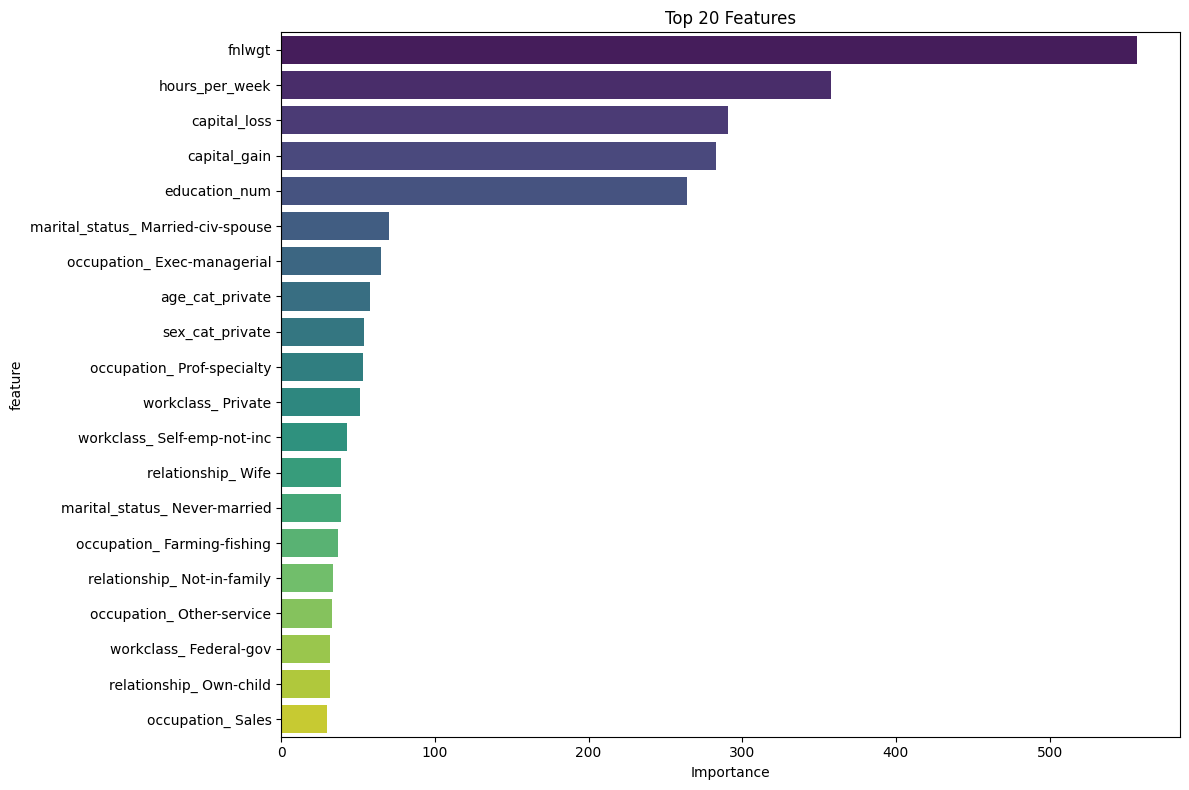

                               feature  importance
0                               fnlwgt         557
4                       hours_per_week         358
3                         capital_loss         291
2                         capital_gain         283
1                        education_num         264
32  marital_status_ Married-civ-spouse          70
40         occupation_ Exec-managerial          65
6                      age_cat_private          58
5                      sex_cat_private          54
46          occupation_ Prof-specialty          53
9                   workclass_ Private          51
11         workclass_ Self-emp-not-inc          43
56                  relationship_ Wife          39
34       marital_status_ Never-married          39
41         occupation_ Farming-fishing          37
52         relationship_ Not-in-family          34
44           occupation_ Other-service          33
7               workclass_ Federal-gov          32
54             relationship_ Ow

In [119]:
get_top_20_feature_importance(selected_model,feature_names)

From the bar chart we can observe that the sex and age features are not of the highest importance for the target. That can explain the non-significant difference in performance of the classifier and the private classifier.

## Creating Fair+Private Model

In [123]:
train_data_faireness = train_data.copy()
train_data_faireness = train_data_faireness.drop(columns=['kfold'])
print(train_data_faireness.shape)

y_faireness = train_data_faireness['income'].copy()

(24134, 19)


In [125]:
os.makedirs("../model/lgbm_fair_private", exist_ok=True)

In [127]:
def prepare_reweighed_dataset(df):

    rw_df = df.copy()

    privileged_groups = [{"age_cat_private":1,"sex_cat_private":1}]
    unprivileged_groups = [{"age_cat_private":0,"sex_cat_private":0}]
    protected_columns = ["age_cat_private","sex_cat_private"]

    dataset = BinaryLabelDataset(
        df=rw_df, 
        label_names=['income'],
        protected_attribute_names=protected_columns,
        favorable_label=1
    )
    
    reweigher = Reweighing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups
    )

    reweighed_dataset = reweigher.fit_transform(dataset)

    new_weights = reweighed_dataset.instance_weights
    rw_df['weights'] = new_weights
    
    return rw_df

def run_folds_faireness(df,fold,model, epsilon_value):
    

    categorical_cols = [
                'workclass', 'education', 'marital_status', 'occupation',
                'relationship', 'race', 'native_country'
                        ]
    numerical_cols = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex_cat_private','age_cat_private']

    preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
            ])

    
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    

    x_train = df_train.drop(columns=['income','age', 'sex', 'age_cat', 'sex_cat', 'kfold'],axis=1)
    y_train = df_train.income.values

    x_valid = df_valid.drop(columns=['income','age', 'sex', 'age_cat', 'sex_cat', 'kfold'],axis=1)
    y_valid = df_valid.income.values
    
    x_train = preprocessor.fit_transform(x_train)
    x_valid = preprocessor.transform(x_valid)

    feature_names = (
                    numerical_cols +  # First, add numerical column names
                    list(preprocessor.named_transformers_['cat'].get_feature_names_out())
                            )
    
    train_transformed_df = pd.DataFrame(
                        x_train, 
                        columns=feature_names)
    
    train_transformed_df['income'] = y_train


    train_reweighed_df = prepare_reweighed_dataset(train_transformed_df)

    x_train_reweighed = train_reweighed_df.drop(columns=['income', 'weights'])
    y_train_reweighed = train_reweighed_df['income']
    sample_weights = train_reweighed_df['weights']

    train_data = lgb.Dataset(
        x_train_reweighed, 
        label=y_train_reweighed, 
        weight=sample_weights
    )

    val_data = lgb.Dataset(
        x_valid, 
        label=y_valid, 
        reference=train_data
    )

    params = {
        'objective': 'binary',  # Adjust based on your problem
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'verbose' : -1
    }

    model_reweighed = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=100  
    )
    
    y_train_pred = (model_reweighed.predict(x_train_reweighed) > 0.5).astype(int)
    y_valid_pred = (model_reweighed.predict(x_valid) > 0.5).astype(int)
    
    train_precision = precision_score(y_train, y_train_pred, average='macro')  
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    train_f1_score = f1_score(y_train, y_train_pred, average='macro')


    valid_precision = precision_score(y_valid, y_valid_pred, average='macro')  
    valid_recall = recall_score(y_valid, y_valid_pred, average='macro')
    valid_f1_score = f1_score(y_valid, y_valid_pred, average='macro')

    joblib.dump(preprocessor,f"../model/{model}_private/preprocessing_{fold}_private_{epsilon_value}.pkl")
    joblib.dump(model_reweighed,f"../model/{model}_private/{model}_{fold}_private_{epsilon_value}.pkl")



    print(f'Fold {fold}')
    print(f'Train F1 Score:{train_f1_score}, Train Precision:{train_precision}, Train Recall: {train_recall}')
    print(f'Validation F1 Score:{valid_f1_score}, Validation Precision:{valid_precision}, Validation Recall: {valid_recall}')
    print('*'*50)
    
    
    return train_precision, train_recall, train_f1_score , valid_precision, valid_recall, valid_f1_score

def get_model_stats_faireness(train_data,model_name,n_folds, epsilon_value):
    train_p = []
    train_r = []
    train_f1 = []
    val_p = []
    val_r = []
    val_f1 = []
    
    train_data = create_folds(train_data,n_folds)

    for i in range(n_folds):

        tp, tr, tf1, vp, vr, vf1 = run_folds_faireness(train_data,i,model_name,epsilon_value)
        train_p.append(tp)
        train_r.append(tr)
        train_f1.append(tf1)
        val_p.append(vp)
        val_r.append(vr)
        val_f1.append(vf1)
    

    print("*"*15,f"Final Summary, Epsilon = {epsilon_value}","*"*15)

    print(f"average training precision:{np.array(train_p).mean()}")
    print(f"average training recall:{np.array(train_r).mean()}")
    print(f"average training f1:{np.array(train_f1).mean()}")


    print(f"average validation precision:{np.array(val_p).mean()}")
    print(f"average validation recall:{np.array(val_r).mean()}")
    print(f"average validation f1:{np.array(val_f1).mean()}")

In [129]:
get_model_stats_faireness(train_data_faireness,'lgbm_fair',5, 0.5)

Fold 0
Train F1 Score:0.8338583208542785, Train Precision:0.860859534592668, Train Recall: 0.8146101775620744
Validation F1 Score:0.8056085053829838, Validation Precision:0.8388119974382694, Validation Recall: 0.7841114234895863
**************************************************
Fold 1
Train F1 Score:0.8353234233937317, Train Precision:0.8613039336095398, Train Recall: 0.8165885332691561
Validation F1 Score:0.7993263190432498, Validation Precision:0.823699860212761, Validation Recall: 0.7822000114751276
**************************************************
Fold 2
Train F1 Score:0.8306099614515129, Train Precision:0.8563175153790126, Train Recall: 0.8121178334795915
Validation F1 Score:0.8172511818761095, Validation Precision:0.8375085000192453, Validation Recall: 0.8020298629612297
**************************************************
Fold 3
Train F1 Score:0.8373951563525494, Train Precision:0.8624005866770579, Train Recall: 0.8191518885304823
Validation F1 Score:0.7922701497053837, Validati

In [131]:
fold=2
epsilon_value=0.5
model="lgbm_fair"

In [133]:
selected_processor_fair_private = joblib.load(f"../model/{model}_private/preprocessing_{fold}_private_{epsilon_value}.pkl")
selected_model_fair_private = joblib.load(f"../model/{model}_private/{model}_{fold}_private_{epsilon_value}.pkl")

In [135]:
X_test = test_data.drop(columns=['age','sex','income', 'age_cat', 'sex_cat'])
y_test = test_data.income

In [137]:
x_test_transf = selected_processor_fair_private.transform(X_test)

In [139]:
y_test_pred = (selected_model_fair_private.predict(x_test_transf)>0.5).astype(int)

In [141]:
test_data['income_pred'] = y_test_pred

In [143]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4527
           1       0.78      0.64      0.70      1501

    accuracy                           0.87      6028
   macro avg       0.84      0.79      0.81      6028
weighted avg       0.86      0.87      0.86      6028



### Fairness assessment for fair+private model

In [146]:
fm_age_1 = fairness_metrics(test_data[test_data.age_cat==1])
fm_age_0 = fairness_metrics(test_data[test_data.age_cat==0])

#Get ratio of fairness metrics
fm_age = fm_age_0/fm_age_1

get_faireness_stats([fm_age_1,fm_age_0,fm_age],['Senior','Young','Ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
Senior,0.841781,0.641165,0.070966,0.358835,0.243792
Young,0.971429,0.541667,0.019452,0.458333,0.030303
Ratio,1.154015,0.844817,0.274101,1.277280,0.124299


In [148]:
# Privileged Group is Male and Unprivileged Group is Female
fm_sex_1 = fairness_metrics(test_data[test_data.sex_cat==1])
fm_sex_0 = fairness_metrics(test_data[test_data.sex_cat==0])

#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1


get_faireness_stats([fm_sex_1,fm_sex_0,fm_sex],['male','female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
male,0.833128,0.645800,0.082471,0.354200,0.257445
female,0.935878,0.606695,0.018540,0.393305,0.090076
ratio,1.123330,0.939446,0.224807,1.110406,0.349885


In [150]:
fm_sex_1_age_1 = fairness_metrics(test_data[(test_data.sex_cat==1)&(test_data.age_cat==1)])
fm_sex_0_age_0 = fairness_metrics(test_data[(test_data.sex_cat==0)&(test_data.age_cat==0)])

#Get ratio of fairness metrics
fm_sex_age = fm_sex_0_age_0/fm_sex_1_age_1


get_faireness_stats([fm_sex_1_age_1,fm_sex_0_age_0,fm_sex_age],['senior male','young female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
senior male,0.807986,0.647106,0.099445,0.352894,0.299472
young female,0.981928,0.500000,0.012195,0.500000,0.018072
ratio,1.215278,0.772671,0.122632,1.416856,0.060347


In the results of measuring the fairness of the *fair+private model*, we observed the deterioration in the true_positive_rate in comparison to the one obtained for the *fair classifier*. The results can be explained by the fact that the reweighing process is impacted by the prior application of the randomized response. The randomized response gives the false values for certain rows, which, in fact, does not correspond to the actual value. Thus, the reweighing process reweights these kind of rows falsely, which leads to deteoration in the fairness of the model.